<div class="container-fluid" style="background: #1BA39C; margin: wide">
    <div style="text-align: center; padding: 50px">
        <img src="https://www.qubitbyqubit.org/prod/images/index/qubit_logo_singleQ_white%202.svg" width="100px" height="50px">
        <h1 style="color: white; text-align: center;">Challenge Project 3</h1>
        <h3 style="color:lightgrey">Portfolio Optimization</h3>
    </div>
</div>

<!-- Note for future, it would be nice to put the QxQ logo in here via github cdn -->

In [22]:
#Imports!

from qiskit.algorithms import VQE, QAOA, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B, SLSQP
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit.circuit.library import TwoLocal
from qiskit import Aer
from qiskit_finance.applications.optimization import PortfolioOptimization
from qiskit_finance.data_providers import WikipediaDataProvider
from qiskit.utils import algorithm_globals, QuantumInstance
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
%matplotlib widget

<h1 style="text-align: center; color: darkblue"> Motivating Portfolio Optimization</h1>

---

**What does it mean to optimize a portfolio?**

The goal of a financial asset manager is two do two things:
   1. Increase Value
   2. Minimize Risk

In this excercise we are going to use real stock data from 2017 and out of a selection of 5 stocks decide which two would have been the best to select for our portfolio.

<div class="alert alert-info"><b><i>N.B.</i></b> 
Note that the ideal portfolio would have a steadily increasing straight line. You can think of this as increasing value without ever suffering a decrease.
</div>

## Using real financial data

While the access to real-time data usually requires a payment, it is possible to access historical (adjusted) closing prices via Wikipedia and Quandl free of charge, following registration at: https://www.quandl.com/?modal=register.

In [7]:
# Helper functions - these functions will help us solve the portfolio optimization problem
# Don't worry about the details of these functions for now - focus on where they are used in the code

# This function imports stock prices using Quandl and Wikipedia. You can edit the start and end datetimes to consider stock prices over a different time period!
# Data is only availble until April 2018, so use time periods earlier than that.
def import_stock_prices(stocks):
    quandl_token = "HRXZqqxBka_9huabBgoW" 
    wiki = WikipediaDataProvider(
                        token = quandl_token,
                        tickers = stocks,
                        start = datetime.datetime(2016,1,1),
                        end = datetime.datetime(2017,1,1))
    wiki.run()
    return wiki

### Using this function, Let's import some stock data!
We will take $n = 5$ assets for this example. Let's take a look at their stock prices over a period of 1 year in 2017. Can you guess which stocks are represented below?

In [8]:
stocks = [ "AAPL", "NFLX", "AMZN", "IBM", "GOOG"] # NASDAQ tickers. If you want to consider more stocks, look up their tickers and add them to the list!
# Other stock tickers you can add include F, NVDA, GME, etc. 
stock_prices = import_stock_prices(stocks)  # Using one of the helper functions defined above to import stock prices

### Looking at the data
When working with new data, it's always a good idea to try and view it first - let's look at the __*raw*__ data exactly as it comes in: we've written a function that does this for you:

In [9]:
# This function uses matplotlib to plot normalized stock prices
def plot_stock_prices(stock_prices, form="norm"):
    fig, ax = plt.subplots(figsize=(8,6))
    if stock_prices._data:
        for (cnt, s) in enumerate(stocks):
            start = stock_prices._data[cnt][0]
            eq = stock_prices._data[cnt] / start
            min_ = np.min(stock_prices._data[cnt])
            max_ = np.max(stock_prices._data[cnt])
            norm = (stock_prices._data[cnt] - min_)/(max_- min_)
            if form == "norm": ax.plot(norm, label=s)
            elif form == "eq": ax.plot(eq, label=s)
            elif form == "raw": ax.plot(stock_prices._data[cnt], label=s)
            else: raise ValueError("Invalid 'form' value")
        ax.legend()
        key = {"norm":"Normalised", "raw":"Raw", "eq":"Equalized"}
        ax.set_title(f"{key[form]} Yearly Evolution of Stock Prices")
        plt.xticks(rotation=90)
        plt.tight_layout()
        plt.show()
    else:
        print('No wiki data loaded.')

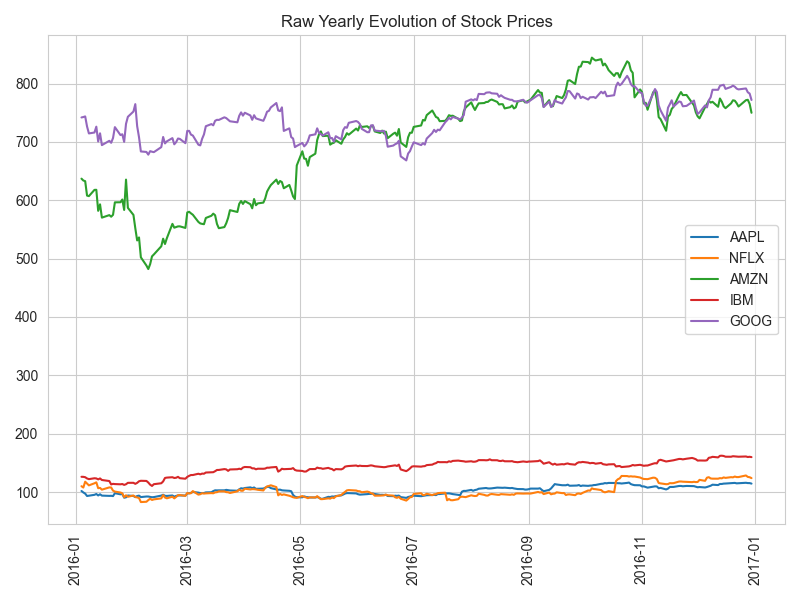

In [10]:
plot_stock_prices(stock_prices, form="raw")

### Initial observations on the raw data
It's important to notice that a share of `AMZN` and `GOOG` costs a lot more than `AAPL`, `IBM`, or `GOOG`. This graph makes it look like `AMZN` and `GOOG` increased by a lot more, but thats only the *dollar amount* what we really care about is the amount they increased *compared* to their starting price.

Therefore, this raw view of the data is relatively unhelpful.

### Overall visualising financial data is tricky

Instead let's equalize their starting points, that way we can imagine that if we invested \$1 in January we can see how much that single dollar would be worth at the end of the year, regardless of the initial share price.

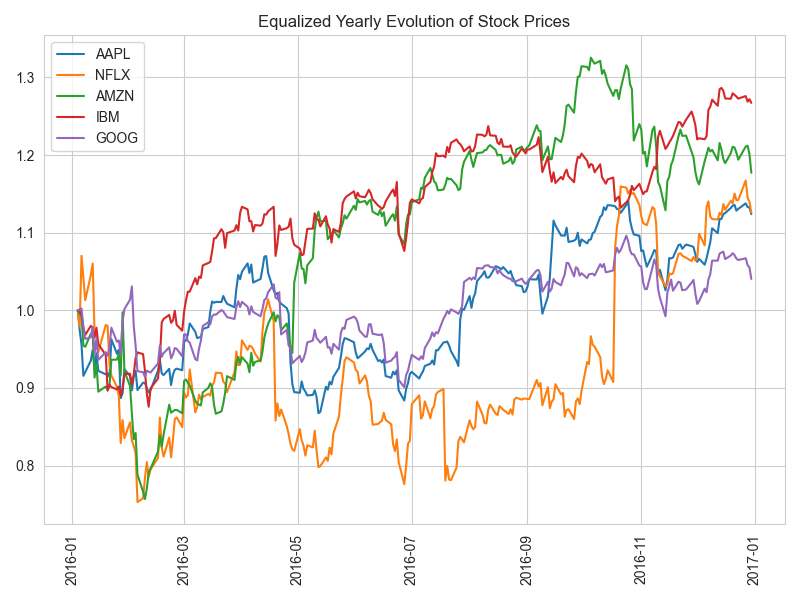

In [11]:
# form="eq" tells our plotting function that we want the starting values to be equalized at the start
plot_stock_prices(stock_prices, form="eq")

## The Intuitive Answer
Looking at this graph we can see that if we had invested $\$1$ into `IBM` at the start of the year we would end the year with around $\$1.25$. That's an enourmous $25%$ increase! 

However, at several points during the year the stock decreases in value. We can intuitively see that by combining both the `AMZN` and `IBM` stocks we could "smooth-out" the graph and reduce our risk so that we get closer to that idealized steadily increasing flat line. 

This is what is known as portfolio optimization. We can computationally calculate which investments will have the highest return while minimizsing the risk.

<h1 style="text-align: center; color: darkblue"> Calculating the Optimal Portfolio</h1>

---

Here, we show how to solve a **mean-variance portfolio optimization problem** for $n$ assets.

Portfolios can be analyzed in a mean-variance framework. We can quantify how risky a selection of investments are by looking at the return variance, and calculate the lowest possible return variance consistent with that investor's chosen level of expected return (called a minimum-variance portfolio).

Under mean-variance analysis, it can be shown that every minimum-variance portfolio given a particular expected return (that is, every efficient portfolio) can be formed as a combination of any two efficient portfolios. If the investor's optimal portfolio has an expected return that is between the expected returns on two efficient benchmark portfolios, then that investor's portfolio can be characterized as consisting of positive quantities of the two benchmark portfolios.

## Portfolio optimization problem

The mean-variance portfolio optimization problem for $n$ assets is defined as:

$$\min\limits_{x\in\{0,1\}^n}qx^T\Sigma x-\mu^Tx$$

$$\texttt{subject to: }1^Tx=B$$

where:

$x\in\{0,1\}^n$ denotes the vector of binary decision variables, which indicate which assets to pick ($x[i]=1$) and which not to pick ($x[i]=0$),

$\mu\in\mathbb{R}^n$ defines the expected returns for the assets,

$\Sigma\in\mathbb{R}^{n\times n}$ specifies the covariances between the assets,

$q>0$ controls the risk appetite of the decision maker,

$B$ denotes the budget, i.e. the number of assets to be selected out of $n$.

## Let's form this into a solvable problem!
We are going to use `qiskits` pre-made `PortfolioOptimization` class. What it does is turn our stock price data into a solvable **quadratic program** which we will call `qp`.

In [12]:
#num of assets (length of our NASDAQ issues array)
num_assets = len(stocks)

# set budget - how many stocks do you want to buy?
budget = 2

# Defining the portfolio optimization problem
portfolio = PortfolioOptimization(expected_returns=stock_prices.get_period_return_mean_vector(),
                                  covariances=stock_prices.get_period_return_covariance_matrix(),
                                  risk_factor=0.2, budget=budget)

# This creates a quadratic program, which is the form in which the problem can be directly
# passed to Qiskit's solvers
qp = portfolio.to_quadratic_program()

Now our `qp` variable contains all the information we need to make this problem solvable

# Let's solve it together using a Classical Solver

### Classical Solver: NumPyMinimumEigensolver 

Let's solve the problem using the same classical solver we used above for the knapsack problem. 

**Reading the result of the solver**: The solver will return a list of 0s and 1s as the optimal knapsack. 0 means that the corresponding stock should not be picked for our portfolio, and 1 means that it should be picked. Therefore, an optimal solution of the form \[0 1 1 0 0\] means that we should pick stocks 2 and 3.

This is hard to read so we've two functions for you called `display_values` which prints out the selected stocks and `plot_portfolio_against_market` which draws a graph of the chosen stocks, their combined portfolio, and the rest of the stocks in the market

In [13]:
# This Function displays teh result of a VQE or Classical EigenSolver
def display_values(vqe_result, stocks):
    lines = []
    for result in vqe_result.samples[:5]:
            qubits, value, probability = result.x, result.fval, result.probability
            q_str = str(qubits.astype(int)).ljust(16)
            arr = np.array(qubits)
            opt = [str(stock[0])+' ' for stock in np.take(stocks, np.argwhere(arr))]
            opt_str = "".join(opt).ljust(16)
            lines.append((opt_str, f'{q_str} {opt_str} {round(value,4)} \t {round(probability,4)}'))

    print(f' Optimal Stock Combination: {lines[0][0]}')
    print('\n------------------------ Top Results ------------------------')
    print('qubits \t\t selection \t value \t\t probability')
    print('--------------------------------------------------------------')
    [print(p[1]) for p in lines]
    print('--------------------------------------------------------------')

# This function draws the value of the portfolio against other the stocks
def plot_portfolio_against_market(result, stock_prices):
    portfolio_sel = np.argwhere(result.samples[0].x).reshape(-1)
    fig, ax = plt.subplots(figsize=(8,6))
    if stock_prices._data:
        portfolio_sum = []
        for (cnt, s) in enumerate(stocks):
            start = stock_prices._data[cnt][0]
            eq = stock_prices._data[cnt] / start
            if cnt in portfolio_sel:
                portfolio_sum.append(eq)
                ax.plot(eq, label=f"{s} (Selected)", linestyle="--", alpha=0.5)
            else:
                ax.plot(eq, label=s, alpha=0.15)
        sab = sum(portfolio_sum)
        # This has no purpose besides shifting the color because I don't like brown
        next(ax._get_lines.prop_cycler)   
        ax.plot(sab/2, label="Portfolio Value")
        ax.set_title("Portfolio Performance") 
        ax.legend()
        plt.xticks(rotation=90)
        plt.tight_layout()
        plt.show()

    else:
        print('No wiki data loaded.')

In [14]:
exact_mes = NumPyMinimumEigensolver() # Specifying the classical solver we want to use - NumPyMinimumEigensolver
exact_eigensolver = MinimumEigenOptimizer(exact_mes) 
result_classical = exact_eigensolver.solve(qp) # Solving the problem using the classical solver

### Display the results
This shows the calculated optimal selection as well as the performance of the portfolio compared to the rest of the stocks in our market

 Optimal Stock Combination: AMZN IBM        

------------------------ Top Results ------------------------
qubits 		 selection 	 value 		 probability
--------------------------------------------------------------
[0 0 1 1 0]      AMZN IBM         -0.0017 	 1.0
--------------------------------------------------------------


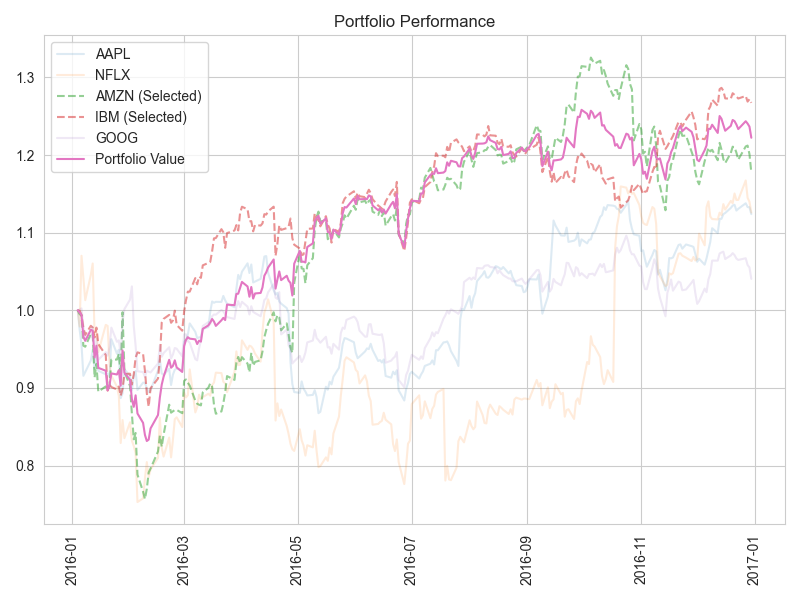

In [15]:
display_values(result_classical, stocks)
plot_portfolio_against_market(result_classical, stock_prices)

# Now it's your turn!

## Quantum Solver: VQE

Now, let's solve the same problem using VQE. Use your lab to make a VQE solver using `TwoLocal` circuit and the `COBYLA` optimiser. The variable `vqe` should be equal to a `MinimumEigenOptimizer` object.

In [16]:
### Solution Start ###
seed = 123

algorithm_globals.random_seed = 1234
backend = Aer.get_backend('qasm_simulator') # Quantum simulator

# This is the quantum part of VQE
quantum_circuit = TwoLocal(num_assets, 'ry', 'cz', reps=3, entanglement='full')
cobyla = COBYLA()
cobyla.set_options(maxiter=500) # This is the classical optimizer we will use

quantum_instance = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed)

# Now, we will use VQE to solve this problem
vqe_mes = VQE(quantum_circuit, optimizer=cobyla, quantum_instance=quantum_instance) 

vqe = MinimumEigenOptimizer(vqe_mes)

#### Solution End ###

# vqe = # TODO

# Test your Results! 
Use this block to test your VQE results, does it look the same as the Classical optimizer?

 Optimal Stock Combination: AMZN IBM        

------------------------ Top Results ------------------------
qubits 		 selection 	 value 		 probability
--------------------------------------------------------------
[0 0 1 1 0]      AMZN IBM         -0.0017 	 0.2256
[0 1 0 1 0]      NFLX IBM         -0.0017 	 0.0234
[1 0 0 1 0]      AAPL IBM         -0.0015 	 0.1279
[0 1 1 0 0]      NFLX AMZN        -0.0014 	 0.0586
[1 0 1 0 0]      AAPL AMZN        -0.0012 	 0.0313
--------------------------------------------------------------


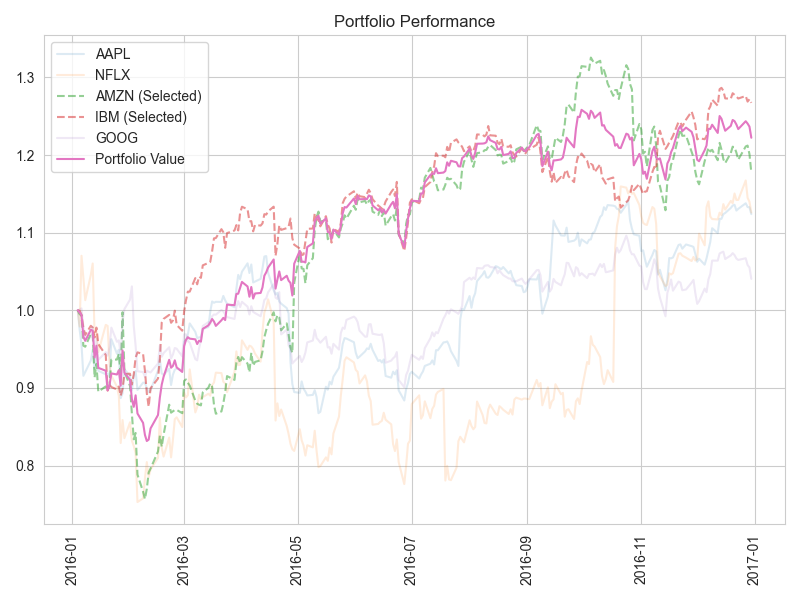

In [17]:
result_vqe = vqe.solve(qp)
display_values(result_vqe, stocks)
plot_portfolio_against_market(result_vqe, stock_prices)

# Extension: Find the best combination of tunable circuits and classical optimizers

Try to run the optimiser on different classical optimizers and graph the convergence results

To do this you will need to create the following callback function:

``` python
values = []
def callback_func(eval_count, parameters, mean, std):
    values.append(mean)
```
And then pass the function as an argument into the VQE object:

``` python
VQE(quantum_circuit, optimizer=optimizer, callback=callback_func, quantum_instance=quantum_instance) 
```
The `values` list will now show the ground state energy of the VQE algorithm at each iteration:



In [18]:
### SOLUTION START ###
stocks = [ "AAPL", "NFLX", "AMZN", "IBM", "GOOG", "F", "NVDA", "GME"] 
stock_prices = import_stock_prices(stocks)  # Using one of the helper functions defined above to import stock prices#num of assets (length of our NASDAQ issues array)

num_assets = len(stocks)

# set budget - how many stocks do you want to buy?
budget = 4

# Defining the portfolio optimization problem
portfolio = PortfolioOptimization(expected_returns=stock_prices.get_period_return_mean_vector(),
                                  covariances=stock_prices.get_period_return_covariance_matrix(),
                                  risk_factor=0.2, budget=budget)

# This creates a quadratic program, which is the form in which the problem can be directly
# passed to Qiskit's solvers
qp = portfolio.to_quadratic_program()

In [19]:
optimizers = {"COBYLA": COBYLA(maxiter=50), "L_BFGS": L_BFGS_B(maxiter=50), "SLSQP": SLSQP(maxiter=50)}
results = []
   
for name, optimizer in optimizers.items():
    print(f"Starting optimizer: {name}")
    values = []
    def callback_func(eval_count, parameters, mean, std):
        values.append(mean)
    quantum_circuit = TwoLocal(num_assets, 'ry', 'cz', reps=3, entanglement='full')
    quantum_instance = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed)
    vqe_mes = VQE(quantum_circuit, optimizer=optimizer, callback=callback_func, quantum_instance=quantum_instance) 
    vqe = MinimumEigenOptimizer(vqe_mes)
    results.append({"name": name, "result": vqe.solve(qp), "values": values})
    print(f"Finished optimizer: {name}")

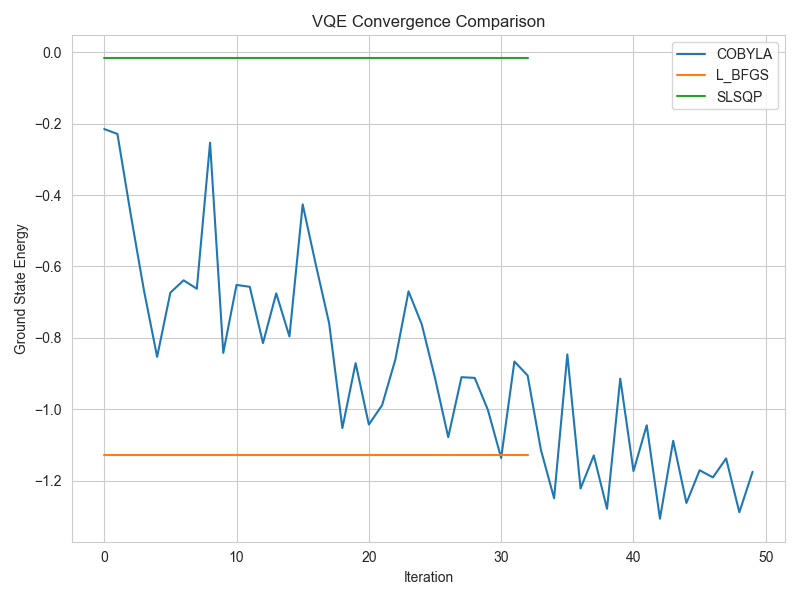

In [21]:
fig, ax = plt.subplots(figsize=(8,6))
ax.set_xlabel("Iteration")
ax.set_ylabel("Ground State Energy")
for test in results:
    ax.plot(test["values"], label=test["name"])
# ax.plot(results[0]["values"], label=results[0]["name"])
ax.set_title("VQE Convergence Comparison") 
ax.legend()
plt.tight_layout()
plt.show()
### SOLUTION END ###